In [28]:
import sympy as sym
import scipy.signal as ss
import matplotlib.pyplot as plt
import numpy as np

In [29]:
def maxZP(H):
    zeroes, poles, gain=ss.tf2zpk(H.num, H.den)
    zMax=abs(max(zeroes, default=0))
    pMax=abs(min(poles, default=0))
    
    if zMax > pMax:
      if zMax==0:
        return 3
      return np.ceil(np.log10(zMax))+2
    
    else:
      if pMax==0:
        return 3
      return np.ceil(np.log10(pMax))+2

def plotbode(H, fig, ylim = None):
    
    xlim = maxZP(H)   # Cálculo de la máxima frec representativa

    w = np.logspace(-4, xlim, 10000)       # Revisar para graficar facha
    bode = ss.bode(H, w=w)            # Calculo del Bode

    # Creamos las figuras
    #fig = plt.figure(figsize = (13, 4))
    mag, phase = fig.add_subplot(1,2,1), fig.add_subplot(1, 2, 2)
    ejeX = bode[0] / (2*np.pi)
    mag.plot(ejeX, bode[1])
    phase.plot(ejeX, bode[2])

    # Ponemos comentarios
    fig.suptitle('Diagrama de Bode')
    mag.set_title('Magnitud')
    phase.set_title('Fase')
    mag.set_xlabel(r'f [$Hz$] | log')
    phase.set_xlabel(r'f [$Hz$] | log')
    mag.set_ylabel(r'|H(j$\omega$)| [dB]')
    phase.set_ylabel(r'Phase [deg]')

    # Pasamos a escala logaritmica 
    mag.set_xscale('log') 
    phase.set_xscale('log')
    
    # Graficamos
    mag.grid(); phase.grid(); mag.set_ylim(None if not ylim else [-125, 5])
    fig.subplots_adjust(wspace = .4)

In [31]:
def filterImpulse(H, u,  figure, w=1, A=1):
  
  t = np.linspace(0, 1/w, 500, endpoint=False)
  
  if u == "escalon":
    u = A*t
  elif u == "seno":  
    u = A*(np.sin(w*t))

  tout, yout, xout = ss.lsim((H.num, H.den), U=u, T=t)
  figure.plot(tout, yout)
  figure.ylabel("out")
  figure.xlabel('time[sec]')
  #plt.show()

#H=ss.TransferFunction([1],[1,0])
#filterImpulse(H, "escalon", 5, 3)

In [32]:
def plotZerosPoles(H, figure, ax):
  zeros, poles = H.zeros, H.poles

  #fig, ax = plt.subplots()
  ax.scatter(np.real(zeros), np.imag(zeros), c="g", marker="o")
  ax.scatter(np.real(poles), np.imag(poles), c="r", marker="x")

  ax.set_xlabel(r'$\sigma$', fontsize=15)
  ax.set_ylabel(r'$jw$', fontsize=15)
  ax.set_title('Gráfico Polos y Ceros')

  ax.grid(True)
  #plt.show()

#plotZerosPoles(ss.TransferFunction([1, 1, 9], [1, 2 ,1]))

#Parte 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys


AttributeError: ignored

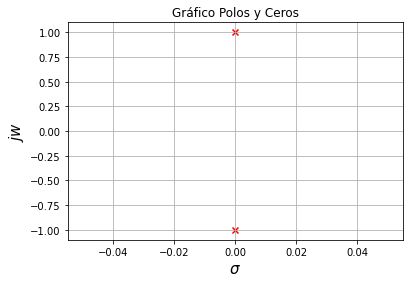

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [34]:
def filterSim (H_num, H_den, figure_scatter, ax_scatter, figure_bode, figure_impulse):
  H=ss.TransferFunction(H_num,H_den)
  plotZerosPoles(H, figure_scatter, ax_scatter)
  filterImpulse(H, u, figure_impulse, w, A)
  plotbode(figure_bode)


num=[1]
den=[1,0,1]
fig1,ax1= plt.subplots()
figuredb=plt.figure()
figureimp=plt.figure()
filterSim(H_num=[1],H_den=[1,0,1], figure_scatter=fig1, ax_scatter=ax1, figure_bode=figuredb, figure_impulse=figureimp)

fig1.show()
figuredb.show()
figureimp.show()



# Parte 2

In [ ]:
# Segunda Parte
def sumTransfer(a, b):
    return  [ np.polyadd( np.polymul( a[0], b[1] ), np.polymul( b[0], a[1] ) ), np.polymul(a[1], b[1]) ]

def RLCSim(punta1=1 , punta2=2, R=0, L=0, C=0):
    
    # H_base = s*C/(s^2LC+sCR+1)
    # Z = s^2*L + s*R + 1/C

    H_base = [ [ C, 0 ],[ L*C, R*C, 1 ] ]
    
    H_R = [ [ R ]   ,    [ 1 ] ]
    H_L = [ [ L, 0 ],    [ 1 ] ]
    H_C = [ [ 1 ]   , [ C, 0 ] ]
    
    # Setear H_2 en base a las puntas
    H_2 = [ [ 0 ], [ 1 ] ]

    puntaMin = min(punta1, punta2)
    puntaMax = max(punta1, punta2)

    tipRange = range(puntaMin, puntaMax+1)

    if (all(node in tipRange for node in [1,2])):           # Resistencia
        H_2 = sumTransfer(H_2, H_R)

    if (all(node in tipRange for node in [2,3])):           # Inductor
        H_2 = sumTransfer(H_2, H_L)

    if (all(node in tipRange for node in [3,4])):           # Capacitor
        H_2 = sumTransfer(H_2, H_C)

    if (puntaMin != punta1):                                # Las pinzas estan invertidas?
        H_2[0] = np.polymul(H_2[0],-1)

    H = ss.TransferFunction(np.polymul(H_base[0], H_2[0]), np.polymul(H_base[1], H_2[1]))
    
    if (np.array_equal(H.num, H.den)):  # Se rompe si H=1
      H = ss.TransferFunction([1], [1])
      
    plotbode(H)

RLCSim(2, 4, 10, 10E-3, 10E-6)